In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch

In [3]:
import ifbo

In [4]:
# if necessary
# !pip install matplotlib

In [5]:
from matplotlib import pyplot as plt

# A look at the curve prior :)

As described in section 4.2 of the main paper, our prior models the interaction between hyperparameter values and their learning curve. In the figure below, we sample 50 hyperparameters (three dimensions) and their respective learning curves. Curves are colored according to the hyperparameter values (i.e., similar hyperparameters have similar colors). 

In [6]:
hyperparameters, curves = ifbo.priors.ftpfn_prior.sample_curves(num_hyperparameters=50, hyperparameter_dimensions=3, curve_length=100)

(0.0, 1.0)

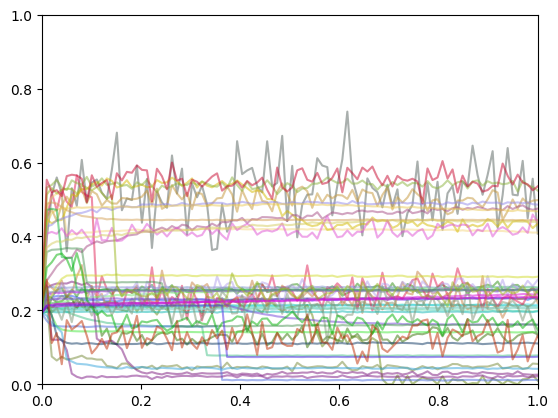

In [7]:
for hp, curve in zip(hyperparameters, curves):
    plt.plot(np.linspace(0, 1, curve.shape[0]), curve, color=hp.tolist() + [0.5])
plt.xlim(0, 1)
plt.ylim(0, 1)

# Batch: a set of observations and a set of queries

During training, we first sample curves and hyperparameters from the prior (see above), then subsample a set of observations to be the ``context`` and ``target`` points. The subsampling strategy is explained in Appendix A.2. 

In [8]:
single_eval_pos = 700
batch = ifbo.priors.ftpfn_prior.get_batch(
    batch_size=1,
    seq_len=1000, # maximum number of observations per task for training. Default: 1000.
    num_features=12, # sample the dimension of HPs with Uniform(1, num_features-1). Default: 12.
    single_eval_pos=single_eval_pos # number of observations in the context (< seq_len).
)
batch.x.shape, batch.y.shape

(torch.Size([1000, 1, 4]), torch.Size([1000, 1]))

As you can see, the ``batch`` is a tensor object containing a set of observations and queries. Each observation includes the ID curve, the epoch (in $[0,1]$), and the hyperparameter values (max 10 dimensions). To ease visualization, we provide a ``detokenize`` that converts the batch to a simpler data format (see ``ifbo.Curve``). 

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

context, query = ifbo.utils.detokenize(batch, context_size=single_eval_pos, device=device)

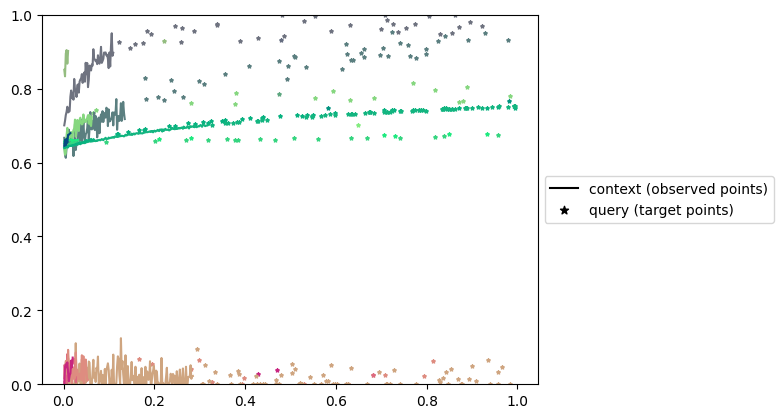

In [10]:
for curve in context:
    plt.plot(curve.t.cpu(), curve.y.cpu(), color=curve.hyperparameters[:3].cpu().numpy().tolist() + [0.5])
for curve in query:
    plt.scatter(curve.t.cpu(), curve.y.cpu(), color=curve.hyperparameters[:3].cpu().numpy().tolist() + [0.5], s=7, marker="*")
_ = plt.ylim(0, 1)

plt.plot([], [], color='black', label='context (observed points)')
plt.scatter([], [], color='black', marker='*', linestyle='None', label='query (target points)')
_ = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Now, run an inference ...

In [11]:
model = ifbo.surrogate.FTPFN(version="0.0.1", device=device)

File already exists at /work/dlclarge1/mallik-lcpfn-hpo/misc/herilalaina/ifbomain/examples/.model!


In [12]:
predictions = model.predict(context=context, query=query)
predictions[0].ucb().shape, predictions[0].quantile(0.5).shape

(torch.Size([39]), torch.Size([39]))

``predictions`` stores a list of ``ifbo.PredictionResult`` objects, from which you can directly access different criterion such as ``ucb``, ``ei``, ``pi``, ``likelihood``, or ``quantile``. It has the same size as ``query``.

## Toy example: 

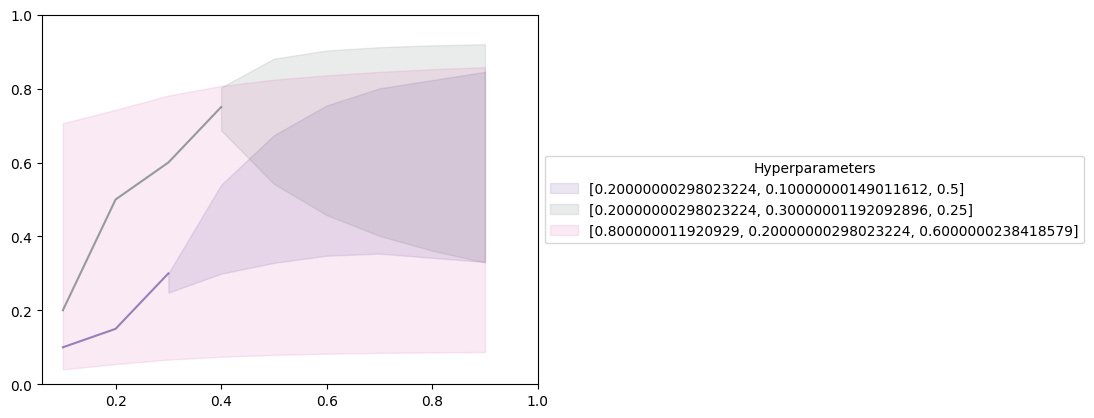

In [13]:
import torch
from ifbo import Curve

context = [
    Curve(hyperparameters=torch.tensor([0.2,0.1,0.5]), t=torch.tensor([0.1,0.2,0.3]), y=torch.tensor([0.1, 0.15, 0.3])),
    Curve(hyperparameters=torch.tensor([0.2,0.3,0.25]), t=torch.tensor([0.1,0.2,0.3,0.4]), y=torch.tensor([0.2, 0.5, 0.6, 0.75])),
]

query = [
    Curve(hyperparameters=torch.tensor([0.2, 0.1, 0.5]), t=torch.tensor([0.3, 0.4, 0.5, 0.6, 0.7, 0.9])),
    Curve(hyperparameters=torch.tensor([0.2, 0.3, 0.25]), t=torch.tensor([0.4, 0.5, 0.6, 0.7, 0.8, 0.9])),
    Curve(hyperparameters=torch.tensor([0.8, 0.2, 0.6]), t=torch.tensor([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])),
]
predictions = model.predict(context=context, query=query)

for curve in context:
    plt.plot(curve.t, curve.y, color=curve.hyperparameters.numpy().tolist() + [0.5])
for curve, pred in zip(query, predictions):
    plt.fill_between(curve.t, pred.quantile(0.05).cpu(), pred.quantile(0.95).cpu(), color=curve.hyperparameters.numpy().tolist() + [0.1], label=curve.hyperparameters.numpy().tolist())
_ = plt.ylim(0, 1), plt.xlim(None, 1)
_ = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Hyperparameters")